# **Introduction**

The electoral results of the Trump era (2015-present) have been defined by realignment along several demographic lines. Throughout this period, President Trump has made inroads with non-white voters, union voters and financially disadvantaged voters; all traditionally Democratic constituencies.

A narrative has emerged that Senator Sanders's 2016 Democratic Primary campaign, fueled by populist sentiment and anti-establishment anger, was a precursor to Trump's eventual electoral success. This narrative posits that a sizable portion of 'Bernie 2016' voters have drifted towards Trump and out of the Democratic party. Given President Trump's significant gains in the popular vote between 2016 and 2024, were these gains concentrated in areas that gave Senator Sanders their support?

This project examines whether the data supports this narrative. The calculation below explores if there is a correlation between improvement in President Trump's vote share between the 2016 and 2024 Presidential elections and Senator Sanders's 2016 campaign vote in the Commonwealth of Massachusetts.

The data was sourced from the [Massachusetts Secretary of State's office](https://electionstats.state.ma.us/).

In [ ]:
# Installing libraries

import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Loading datasets into dataframes

df_2024 = pd.read_csv("PD43+__2024_President_General_Election.csv")
df_2016 = pd.read_csv("PD43+__2016_President_General_Election.csv")
df_2016_dem = pd.read_csv("PD43+__2016_President_Democratic_Primary.csv")

While the datasets provided by Secretary Galvin's office were fairly clean, they still required some light cleaning. I dropped unneeded blank columns and stripped out any extra spaces.

I then standardized naming across datasets to make the query less complicated.

Lastly, I took only the columns that were necessary for the calculation and converted them to floats.

In [ ]:
# Data cleaning

df_2024 = df_2024.drop(columns=["Unnamed: 1", "Unnamed: 2"], errors="ignore")
df_2016 = df_2016.drop(columns=["Unnamed: 1", "Unnamed: 2"], errors="ignore")
df_2016_dem = df_2016_dem.drop(columns=["Unnamed: 1", "Unnamed: 2"], errors="ignore")

df_2024.columns = df_2024.columns.str.strip()
df_2016.columns = df_2016.columns.str.strip()
df_2016_dem.columns = df_2016_dem.columns.str.strip()

In [ ]:
# Renaming and standardizing columns

df_2024 = df_2024.rename(columns={
    "City/Town": "city_town",
    "Harris/ Walz": "dem_votes",
    "Trump/ Vance": "rep_votes",
    "Total Votes Cast": "total_votes"
})

df_2016 = df_2016.rename(columns={
    "City/Town": "city_town",
    "Clinton/ Kaine": "dem_votes",
    "Trump/ Pence": "rep_votes",
    "Total Votes Cast": "total_votes"
})

df_2016_dem = df_2016_dem.rename(columns={
    "City/Town": "city_town",
    "Hillary Clinton": "clinton_votes",
    "Bernie Sanders": "sanders_votes",
    "Total Votes Cast": "total_votes"
})

In [ ]:
# Isolating necessary columns

df_2024 = df_2024[["city_town", "dem_votes", "rep_votes", "total_votes"]]
df_2016 = df_2016[["city_town", "dem_votes", "rep_votes", "total_votes"]]
df_2016_dem = df_2016_dem[["city_town", "clinton_votes", "sanders_votes", "total_votes"]]

In [ ]:
# Function to clean numeric columns
def clean_numeric_columns(df, columns):
    for col in columns:
        df[col] = df[col].astype(str).str.replace(",", "").astype(float)
    return df

# Identify numeric columns that need cleaning
numeric_columns_2024 = ["total_votes", "rep_votes", "dem_votes"]
numeric_columns_2016 = ["total_votes", "rep_votes", "dem_votes"]
numeric_columns_2016_dem = ["total_votes", "clinton_votes", "sanders_votes"]

# Clean the datasets
df_2024 = clean_numeric_columns(df_2024, numeric_columns_2024)
df_2016 = clean_numeric_columns(df_2016, numeric_columns_2016)
df_2016_dem = clean_numeric_columns(df_2016_dem, numeric_columns_2016_dem)

In [ ]:
# Storing dataframes to SQL

conn = sqlite3.connect(":memory:")

df_2024.to_sql("election_2024", conn, if_exists="replace", index=False)
df_2016.to_sql("election_2016", conn, if_exists="replace", index=False)
df_2016_dem.to_sql("primary_2016_democratic", conn, if_exists="replace", index=False)

353

I created two CTEs to calculate the change in President Trump's vote share between the 2016 and 2024 Presidential elections and Senator Sanders' vote share in the 2016 Democratic primary.

In [ ]:
#Creating CTEs and running query

query = """
WITH rep_vote_share_change AS (
    SELECT
        e2024.city_town,
        (SUM(e2024.rep_votes) * 1.0 / SUM(e2024.total_votes) -
         SUM(e2016.rep_votes) * 1.0 / SUM(e2016.total_votes)) AS rep_vote_share_change
    FROM election_2024 e2024
    LEFT JOIN election_2016 e2016 USING(city_town)
    GROUP BY e2024.city_town
),
sanders_vote_share AS (
    SELECT
        city_town,
        (SUM(sanders_votes) * 1.0 / (SUM(clinton_votes) + SUM(sanders_votes))) AS sanders_pct_2016
    FROM primary_2016_democratic
    GROUP BY city_town
)
SELECT v.city_town, v.rep_vote_share_change, s.sanders_pct_2016
FROM rep_vote_share_change v
LEFT JOIN sanders_vote_share s USING(city_town)
WHERE v.rep_vote_share_change IS NOT NULL;
"""

In [ ]:
#Execute the query
df_analysis = pd.read_sql_query(query, conn)
print(df_analysis)

conn.close()

       city_town  rep_vote_share_change  sanders_pct_2016
0       Abington               0.028743          0.545312
1          Acton              -0.006805          0.470114
2       Acushnet               0.107592          0.492228
3          Adams               0.062523          0.521472
4         Agawam               0.030105          0.534085
..           ...                    ...               ...
347       Woburn               0.002746          0.509845
348    Worcester               0.073993          0.489372
349  Worthington               0.035860          0.719198
350     Wrentham               0.017702          0.549304
351     Yarmouth              -0.000733          0.477188

[352 rows x 3 columns]


In [ ]:
# Correlation calculation

correlation_value = df_analysis["rep_vote_share_change"].corr(df_analysis["sanders_pct_2016"])

print(f"Correlation between Sanders 2016 vote share and Republican vote change (2016-2024): {correlation_value:.4f}")

Correlation between Sanders 2016 vote share and Republican vote change (2016-2024): 0.0372


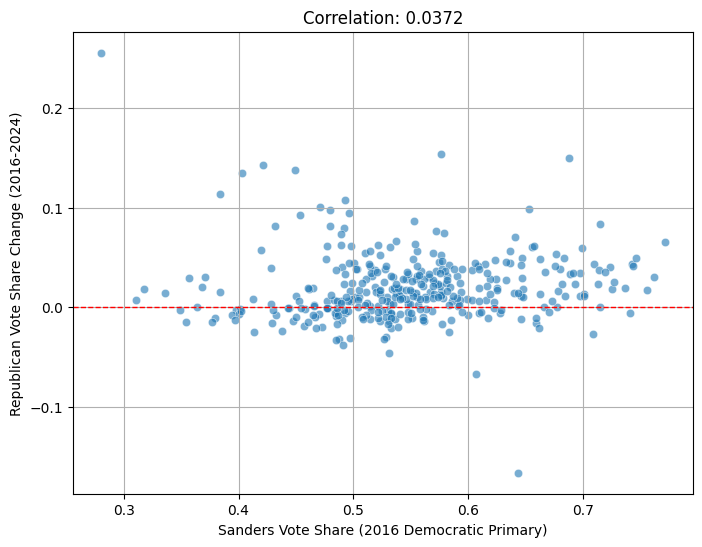

In [ ]:
# Visualization

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_analysis,
    x="sanders_pct_2016",
    y="rep_vote_share_change",
    alpha=0.6
)
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Reference line at zero change
plt.xlabel("Sanders Vote Share (2016 Democratic Primary)")
plt.ylabel("Republican Vote Share Change (2016-2024)")
plt.title(f"Correlation: {correlation_value:.4f}")
plt.grid(True)

# Show the plot
plt.show()

# **Conclusion**

This analysis found little correlation (.0372) betweeen Senator Sanders's 2016 primary result and President Trump's electoral gains from 2016 to 2024. While a slight positive trend is present, it is far too weak to conclude that a relationship exists between the two.

This result suggests that proponents of the narrative that many of Senator Sanders's voters eventually became supporters of President Trump does not explain the President's gains in Massachusetts.

If this analysis were to be expanded, additional factors could be considered including demographic, turnout, or economic variables.